# Riverbank Erosion Impact and Household Adaptation Strategy Analysis
## Advanced Machine Learning Implementation

**Setup Instructions:**
1. Update DRIVE_PATH variable to your Google Drive folder location
2. Enable GPU runtime for faster processing
3. Execute all cells sequentially

**Author:** Yousuf Rayhan Emon  
**Date:** November 2025

## Setup: Mount Drive and Install Dependencies

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install xgboost lightgbm catboost shap lime -q
print('Packages installed successfully')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.2 MB/s eta 0:00:00
Packages installed successfully


## Configuration

In [4]:
# CONFIGURE THESE PATHS
DRIVE_PATH = '/content/drive/Shareddrives/Thesis_Preparation/NTK_River'
DATA_FILE = 'riverbank_with_indices.csv'

import os
os.chdir(DRIVE_PATH)
print(f'Working directory: {os.getcwd()}')
print(f'\nFiles in directory:')
for f in os.listdir('.')[:10]:
    print(f'  - {f}')

if not os.path.exists(DATA_FILE):
    print(f'\nERROR: {DATA_FILE} not found in {DRIVE_PATH}')
    print('Please upload the dataset to the specified directory')
else:
    print(f'\nDataset found: {DATA_FILE}')

Working directory: /content/drive/Shareddrives/Thesis_Preparation/NTK_River

Files in directory:
  - riverbank_balanced.csv
  - riverbank_with_indices.csv
  - Data Preprocessing.ipynb
  - Prediction Modeling.ipynb
  - thesis_results.zip
  - Complete_Analysis_Colab_WithEmoji.ipynb
  - processed_data
  - models
  - results
  - figures

Dataset found: riverbank_with_indices.csv


In [5]:
os.makedirs('processed_data', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('figures', exist_ok=True)
print('Output directories created')

Output directories created


## Import Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                           classification_report, confusion_matrix, ConfusionMatrixDisplay,
                           roc_auc_score, roc_curve, auc)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from scipy import stats
from scipy.stats import chi2_contingency, kruskal
from scipy.cluster.hierarchy import dendrogram, linkage

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import shap
from lime import lime_tabular

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Enhanced plot settings for publication quality
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 14
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

print('Libraries imported successfully')

Libraries imported successfully


In [26]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, roc_auc_score, classification_report)
from sklearn.preprocessing import label_binarize
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import joblib

# STEP 1: Data Preparation and Feature Engineering

In [7]:
print('='*80)
print('STEP 1: DATA PREPARATION & FEATURE ENGINEERING')
print('='*80)

# Load data
df = pd.read_csv(DATA_FILE)
print(f'\nDataset shape: {df.shape}')
print(f'\nTarget distribution:')
print(df['Adaptation_Category'].value_counts())
print(f'\nClass balance: {df["Adaptation_Category"].value_counts().min() / df["Adaptation_Category"].value_counts().max():.3f}')

STEP 1: DATA PREPARATION & FEATURE ENGINEERING

Dataset shape: (2967, 25)

Target distribution:
Adaptation_Category
Non-Adaptive           991
Strongly Adaptive      990
Moderately Adaptive    986
Name: count, dtype: int64

Class balance: 0.995


In [8]:
df_eng = df.copy()

print('Engineering domain-specific features...')

# Vulnerability patterns
df_eng['vulnerability_index'] = df_eng['EII'] / (df_eng['ASI'] + 0.01)
df_eng['resilience_capacity'] = df_eng['SRI'] * df_eng['ASI']
df_eng['adaptation_gap'] = df_eng['EII'] - df_eng['ASI']

# Institutional effectiveness
awareness_map = {'Low': 0, 'Moderate': 1, 'High': 2}
df_eng['awareness_num'] = df_eng['Awareness_Level'].map(awareness_map)
df_eng['institutional_effectiveness'] = df_eng['ISS'] * (df_eng['awareness_num'] / 2.0)

# Socioeconomic capacity
education_map = {'Not Educated': 0, 'Partially Educated': 1, 'Educated': 2}
df_eng['education_num'] = df_eng['Education_Level'].map(education_map)
df_eng['economic_stability'] = (
    df_eng['Monthly_Income'] / df_eng['Monthly_Income'].max() *
    (df_eng['education_num'] / 2.0)
)

# Hazard exposure
df_eng['exposure_intensity'] = (
    df_eng['Distance_score'] *
    df_eng['Previous_Erosion_Experience'].map({'Yes': 1, 'No': 0})
)

# Adaptive behavior
adaptive_actions = [
    'Access_to_Warning', 'Govt_or_NGO_Assistance',
    'Has_Protection_System', 'Income_Diversification',
    'Involved_in_Community_Adaptation'
]
df_eng['adaptive_behavior_count'] = sum(
    df_eng[col].map({'Yes': 1, 'No': 0}) for col in adaptive_actions
)
df_eng['adaptive_behavior_index'] = df_eng['adaptive_behavior_count'] / len(adaptive_actions)

# Demographic vulnerability
df_eng['age_vulnerability'] = np.where(
    (df_eng['Age'] < 25) | (df_eng['Age'] > 55), 1, 0
)
df_eng['demographic_burden'] = (
    df_eng['Family_Size'] / df_eng['Family_Size'].max() *
    (1 + df_eng['age_vulnerability'])
)

# Resource ownership
housing_quality = {'Temporary': 0, 'Semi-Permanent': 1, 'Permanent': 2}
df_eng['housing_quality'] = df_eng['Housing_Type'].map(housing_quality)
df_eng['land_ownership_bin'] = df_eng['Land_Ownership'].map({'Yes': 1, 'No': 0})
df_eng['resource_ownership'] = (
    df_eng['housing_quality'] / 2.0 + df_eng['land_ownership_bin']
) / 2.0

# Past impact
impact_indicators = ['Infrastructure_Loss', 'Relocation_History']
df_eng['past_impact_severity'] = sum(
    df_eng[col].map({'Yes': 1, 'No': 0}) for col in impact_indicators
) / len(impact_indicators)

# Integrated risk
df_eng['integrated_risk'] = (
    df_eng['EII'] * 0.4 +
    df_eng['vulnerability_index'] * 0.3 +
    (1 - df_eng['ASI']) * 0.3
)

# Adaptive capacity ratio
df_eng['adaptive_capacity_ratio'] = (
    (df_eng['SRI'] + df_eng['ISS'] + df_eng['ASI']) / 3.0 /
    (df_eng['EII'] + 0.01)
)

new_features = len([c for c in df_eng.columns if c not in df.columns])
print(f'Created {new_features} engineered features')

Engineering domain-specific features...
Created 18 engineered features


In [9]:
# Prepare feature matrix
numeric_features = [
    'Age', 'Monthly_Income', 'Family_Size',
    'Distance_score', 'EII', 'ASI', 'SRI', 'ISS',
    'vulnerability_index', 'resilience_capacity', 'adaptation_gap',
    'awareness_num', 'institutional_effectiveness',
    'education_num', 'economic_stability',
    'exposure_intensity', 'adaptive_behavior_count', 'adaptive_behavior_index',
    'age_vulnerability', 'demographic_burden',
    'housing_quality', 'land_ownership_bin', 'resource_ownership',
    'past_impact_severity', 'integrated_risk', 'adaptive_capacity_ratio'
]

binary_features = [
    'Previous_Erosion_Experience', 'Access_to_Warning', 'Relocation_History',
    'Govt_or_NGO_Assistance', 'Has_Protection_System', 'Infrastructure_Loss',
    'Income_Diversification', 'Involved_in_Community_Adaptation'
]

categorical_features = ['Union', 'Gender']

# Create feature matrix
X = df_eng.copy()

# Encode binary features
for col in binary_features:
    X[col] = X[col].map({'Yes': 1, 'No': 0})

# One-hot encode categorical features
X = pd.get_dummies(X, columns=categorical_features, drop_first=True, dtype=int)

# Select final features
feature_cols = [c for c in X.columns if c in numeric_features or
               any(cat in c for cat in categorical_features) or
               c in binary_features]

X = X[feature_cols].fillna(0)
y = LabelEncoder().fit_transform(df_eng['Adaptation_Category'])

print(f'\nFeature matrix shape: {X.shape}')
print(f'Total features: {X.shape[1]}')


Feature matrix shape: (2967, 38)
Total features: 38


In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print(f'Training set: {X_train.shape}')
print(f'Testing set: {X_test.shape}')
print(f'\nTraining distribution: {np.bincount(y_train)}')
print(f'Testing distribution: {np.bincount(y_test)}')

Training set: (2373, 38)
Testing set: (594, 38)

Training distribution: [789 792 792]
Testing distribution: [197 199 198]


In [11]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

X_train_scaled.to_csv('processed_data/X_train.csv', index=False)
X_test_scaled.to_csv('processed_data/X_test.csv', index=False)
pd.DataFrame({'y_train': y_train}).to_csv('processed_data/y_train.csv', index=False)
pd.DataFrame({'y_test': y_test}).to_csv('processed_data/y_test.csv', index=False)

class_names = ['Moderately Adaptive', 'Non-Adaptive', 'Strongly Adaptive']

print('Features scaled and saved')
print('\nSTEP 1 COMPLETE\n')

Features scaled and saved

STEP 1 COMPLETE



# STEP 2: Exploratory Data Analysis

In [12]:
print('='*80)
print('STEP 2: EXPLORATORY DATA ANALYSIS')
print('='*80)

STEP 2: EXPLORATORY DATA ANALYSIS


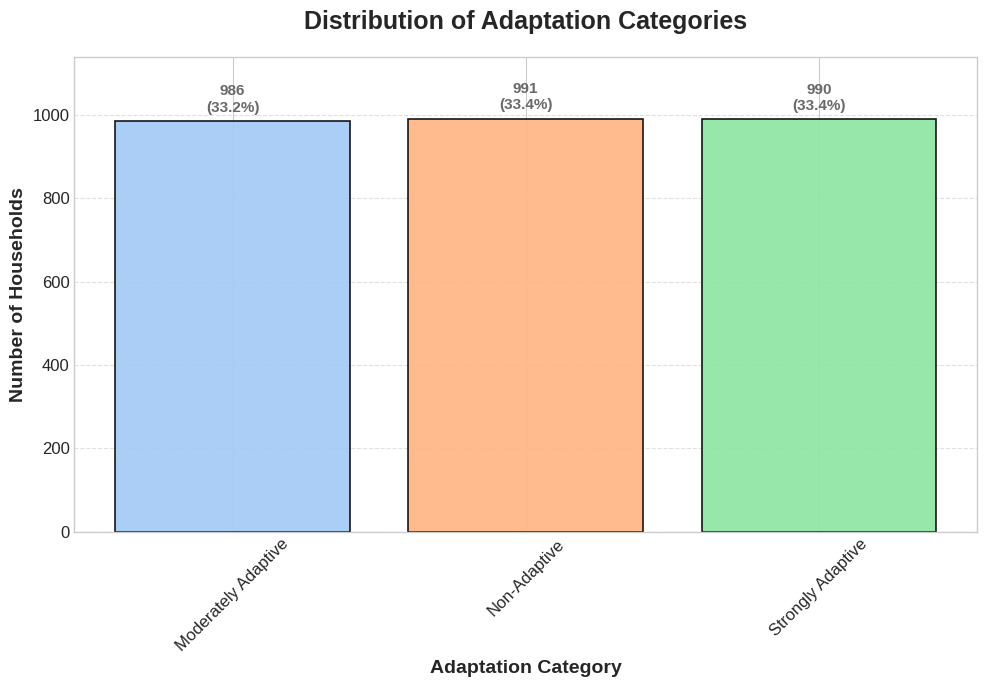

Redesigned Figure 1 saved (600 DPI)


In [14]:
import matplotlib.ticker as mtick # Import for percentage formatting

# Get counts and calculate percentages
counts = df['Adaptation_Category'].value_counts(normalize=False)
percentages = df['Adaptation_Category'].value_counts(normalize=True) * 100

# Define the desired order for categories
category_order = ['Moderately Adaptive', 'Non-Adaptive', 'Strongly Adaptive'] # Using class_names order for consistency

# Reindex counts and percentages to match the desired order
counts = counts.reindex(category_order)
percentages = percentages.reindex(category_order)

# Prepare data for plotting
plot_df = pd.DataFrame({
    'Category': counts.index,
    'Count': counts.values,
    'Percentage': percentages.values
})

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 7))

# Use a professional color palette
colors = sns.color_palette('pastel', n_colors=len(plot_df))

# Create the bar chart
bars = ax.bar(plot_df['Category'], plot_df['Count'], color=colors, edgecolor='black', linewidth=1.2, alpha=0.9)

# Customize the plot
ax.set_title('Distribution of Adaptation Categories', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Adaptation Category', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Households', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Add annotations for count and percentage on top of each bar
for bar in bars:
    height = bar.get_height()
    category = bar.get_x() + bar.get_width() / 2
    count_val = int(height)
    pct_val = plot_df.loc[plot_df['Category'] == plot_df['Category'][bars.index(bar)], 'Percentage'].values[0]
    ax.text(bar.get_x() + bar.get_width() / 2, height + 15,
            f'{count_val}\n({pct_val:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold', color='dimgray')

# Adjust y-axis limit to make space for annotations
ax.set_ylim(0, max(plot_df['Count']) * 1.15)

plt.tight_layout()
plt.savefig('figures/01_target_distribution_redesigned.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print('Redesigned Figure 1 saved (600 DPI)')

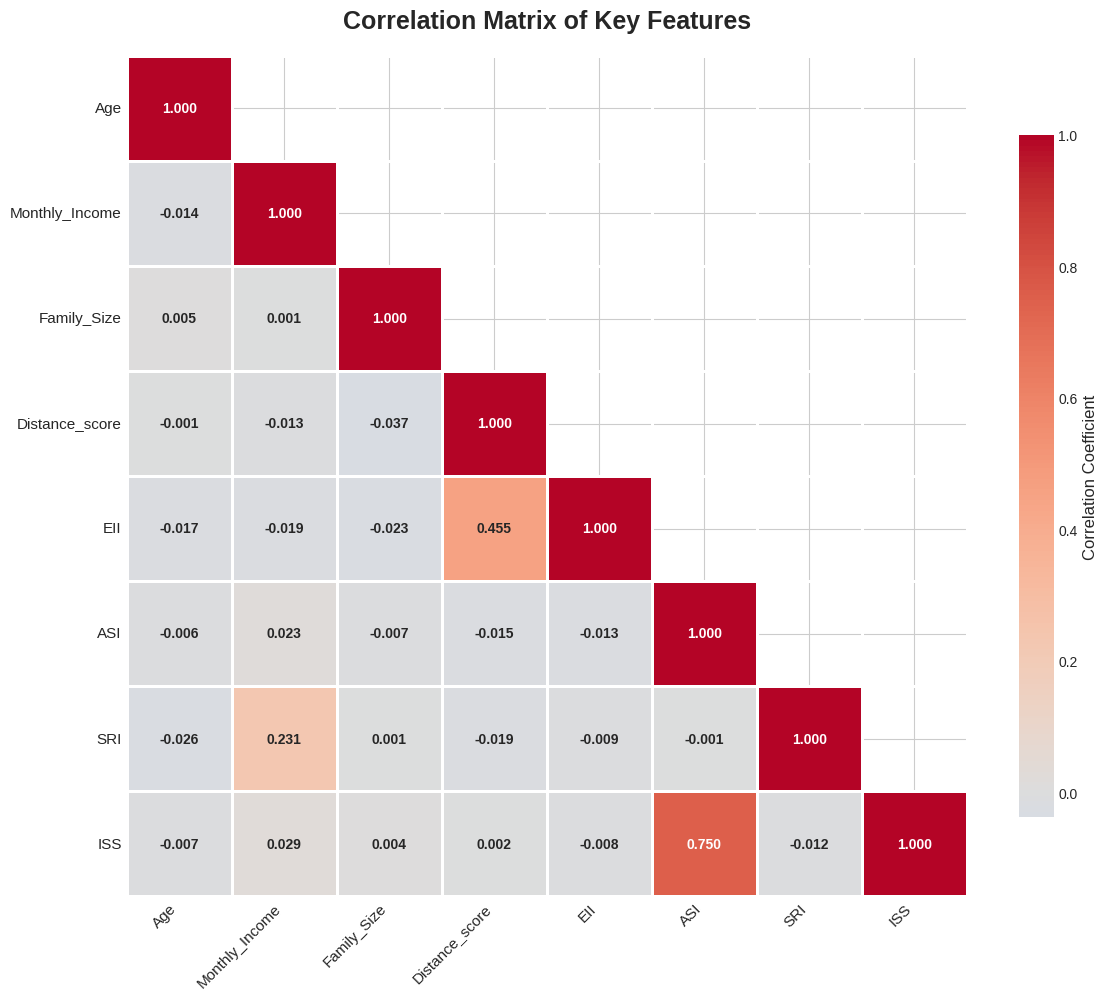

Figure 2 saved (600 DPI)

STEP 2 COMPLETE



In [15]:
numeric_cols = ['Age', 'Monthly_Income', 'Family_Size', 'Distance_score', 'EII', 'ASI', 'SRI', 'ISS']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=2, linecolor='white', cbar_kws={'shrink': 0.8, 'label': 'Correlation Coefficient'},
            annot_kws={'fontsize': 10, 'fontweight': 'bold'})
plt.title('Correlation Matrix of Key Features', fontsize=18, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.savefig('figures/02_correlation_heatmap.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print('Figure 2 saved (600 DPI)')
print('\nSTEP 2 COMPLETE\n')

# STEP 3: Advanced Model Training

In [23]:
print('='*80)
print('STEP 3: ADVANCED MODEL TRAINING')
print('='*80)
print('\nTraining 6 optimized models with 10-fold cross-validation...\n')

STEP 3: ADVANCED MODEL TRAINING

Training 6 optimized models with 10-fold cross-validation...



In [24]:
models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=1000,
        max_depth=25,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        class_weight='balanced',
        bootstrap=True,
        oob_score=True,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),

    'ExtraTrees': ExtraTreesClassifier(
        n_estimators=1000,
        max_depth=25,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        class_weight='balanced',
        bootstrap=True,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),

    'XGBoost': XGBClassifier(
        n_estimators=1000,
        max_depth=9,
        learning_rate=0.008,
        subsample=0.85,
        colsample_bytree=0.85,
        min_child_weight=1,
        gamma=0.15,
        reg_alpha=0.15,
        reg_lambda=1.2,
        scale_pos_weight=1,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric='mlogloss',
        tree_method='gpu_hist' # Added for GPU acceleration
    ),

    'LightGBM': LGBMClassifier(
        n_estimators=1000,
        max_depth=12,
        learning_rate=0.008,
        subsample=0.85,
        colsample_bytree=0.85,
        min_child_samples=15,
        num_leaves=50,
        reg_alpha=0.15,
        reg_lambda=1.2,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=1, # Set to 1 when using device='gpu'
        verbose=-1,
        device='gpu' # Added for GPU acceleration
    ),

    'CatBoost': CatBoostClassifier(
        iterations=1000,
        depth=9,
        learning_rate=0.008,
        l2_leaf_reg=3.5,
        bagging_temperature=0.5,
        random_strength=1.5,
        random_state=RANDOM_STATE,
        verbose=False,
        thread_count=-1, # Or remove if task_type='GPU' handles it
        task_type='GPU' # Added for GPU acceleration
    ),

    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=1000,
        max_depth=9,
        learning_rate=0.008,
        subsample=0.85,
        min_samples_split=8,
        min_samples_leaf=3,
        max_features='sqrt',
        random_state=RANDOM_STATE
    )
}

print(f'Defined {len(models)} models with optimized hyperparameters')

Defined 6 models with optimized hyperparameters


In [27]:
# Configure models with proper GPU settings
models = {}

models['Logistic Regression'] = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

models['Random Forest'] = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# XGBoost - Use GPU properly
models['XGBoost'] = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    tree_method='gpu_hist',
    device='cuda',
    n_jobs=1
)

# LightGBM - Use GPU properly
models['LightGBM'] = LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    device='gpu',
    n_jobs=1,
    verbosity=-1
)

# CatBoost - Use GPU properly
models['CatBoost'] = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    task_type='GPU',
    devices='0',
    verbose=False
)

models['SVM'] = SVC(
    kernel='rbf',
    probability=True,
    random_state=RANDOM_STATE
)

models['Gradient Boosting'] = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_STATE
)

# Cross-validation with GPU models
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
results = []

for name, model in models.items():
    print(f'\n{"="*80}')
    print(f'Training: {name}')
    print(f'{"="*80}')

    try:
        # IMPORTANT: Use n_jobs=1 for GPU models to avoid conflicts
        cv_n_jobs = 1 if name in ['XGBoost', 'LightGBM', 'CatBoost'] else -1

        cv_scores_acc = cross_val_score(model, X_train_scaled, y_train,
                                        cv=cv, scoring='accuracy', n_jobs=cv_n_jobs)
        cv_scores_f1 = cross_val_score(model, X_train_scaled, y_train,
                                       cv=cv, scoring='f1_macro', n_jobs=cv_n_jobs)

        print(f'CV Accuracy: {cv_scores_acc.mean():.4f} +/- {cv_scores_acc.std():.4f}')
        print(f'CV F1-Macro: {cv_scores_f1.mean():.4f} +/- {cv_scores_f1.std():.4f}')

        model.fit(X_train_scaled, y_train)

        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)

        test_acc = accuracy_score(y_test, y_pred)
        test_f1 = f1_score(y_test, y_pred, average='macro')
        test_precision = precision_score(y_test, y_pred, average='macro')
        test_recall = recall_score(y_test, y_pred, average='macro')

        y_test_bin = label_binarize(y_test, classes=range(3))
        roc_auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')

        print(f'\nTest Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)')
        print(f'Test F1-Macro:  {test_f1:.4f}')
        print(f'Test Precision: {test_precision:.4f}')
        print(f'Test Recall:    {test_recall:.4f}')
        print(f'Test ROC-AUC:   {roc_auc:.4f}')

        print(f'\nClassification Report:')
        print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

        results.append({
            'Model': name,
            'CV_Accuracy': cv_scores_acc.mean(),
            'CV_Accuracy_Std': cv_scores_acc.std(),
            'CV_F1': cv_scores_f1.mean(),
            'Test_Accuracy': test_acc,
            'Test_F1': test_f1,
            'Test_Precision': test_precision,
            'Test_Recall': test_recall,
            'Test_ROC_AUC': roc_auc,
            'model_object': model,
            'y_pred': y_pred,
            'y_proba': y_proba
        })

        joblib.dump(model, f'models/{name}.pkl')
        print(f'Model saved to models/{name}.pkl')

    except Exception as e:
        print(f'\nERROR training {name}: {str(e)}')
        print(f'Skipping this model...')
        continue


Training: Logistic Regression
CV Accuracy: 0.9153 +/- 0.0165
CV F1-Macro: 0.9153 +/- 0.0167

Test Accuracy:  0.9158 (91.58%)
Test F1-Macro:  0.9162
Test Precision: 0.9172
Test Recall:    0.9157
Test ROC-AUC:   0.9896

Classification Report:
                     precision    recall  f1-score   support

Moderately Adaptive     0.8621    0.8883    0.8750       197
       Non-Adaptive     0.9789    0.9347    0.9563       199
  Strongly Adaptive     0.9104    0.9242    0.9173       198

           accuracy                         0.9158       594
          macro avg     0.9172    0.9157    0.9162       594
       weighted avg     0.9174    0.9158    0.9163       594

Model saved to models/Logistic Regression.pkl

Training: Random Forest
CV Accuracy: 0.8900 +/- 0.0188
CV F1-Macro: 0.8902 +/- 0.0185

Test Accuracy:  0.8973 (89.73%)
Test F1-Macro:  0.8976
Test Precision: 0.8981
Test Recall:    0.8972
Test ROC-AUC:   0.9788

Classification Report:
                     precision    recall  f1-s

In [28]:
# XGBoost - Fixed for your system
models['XGBoost'] = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    tree_method='hist',  # Changed from 'gpu_hist' to 'hist'
    device='cuda',
    n_jobs=1
)

# Train only XGBoost
name = 'XGBoost'
model = models['XGBoost']

print(f'\n{"="*80}')
print(f'Training: {name}')
print(f'{"="*80}')

cv_n_jobs = 1

cv_scores_acc = cross_val_score(model, X_train_scaled, y_train,
                                cv=cv, scoring='accuracy', n_jobs=cv_n_jobs)
cv_scores_f1 = cross_val_score(model, X_train_scaled, y_train,
                               cv=cv, scoring='f1_macro', n_jobs=cv_n_jobs)

print(f'CV Accuracy: {cv_scores_acc.mean():.4f} +/- {cv_scores_acc.std():.4f}')
print(f'CV F1-Macro: {cv_scores_f1.mean():.4f} +/- {cv_scores_f1.std():.4f}')

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)

test_acc = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='macro')
test_precision = precision_score(y_test, y_pred, average='macro')
test_recall = recall_score(y_test, y_pred, average='macro')

y_test_bin = label_binarize(y_test, classes=range(3))
roc_auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')

print(f'\nTest Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)')
print(f'Test F1-Macro:  {test_f1:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall:    {test_recall:.4f}')
print(f'Test ROC-AUC:   {roc_auc:.4f}')

print(f'\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

results.append({
    'Model': name,
    'CV_Accuracy': cv_scores_acc.mean(),
    'CV_Accuracy_Std': cv_scores_acc.std(),
    'CV_F1': cv_scores_f1.mean(),
    'Test_Accuracy': test_acc,
    'Test_F1': test_f1,
    'Test_Precision': test_precision,
    'Test_Recall': test_recall,
    'Test_ROC_AUC': roc_auc,
    'model_object': model,
    'y_pred': y_pred,
    'y_proba': y_proba
})

joblib.dump(model, f'models/{name}.pkl')
print(f'Model saved to models/{name}.pkl')


Training: XGBoost
CV Accuracy: 0.8909 +/- 0.0149
CV F1-Macro: 0.8912 +/- 0.0146

Test Accuracy:  0.9074 (90.74%)
Test F1-Macro:  0.9076
Test Precision: 0.9082
Test Recall:    0.9073
Test ROC-AUC:   0.9834

Classification Report:
                     precision    recall  f1-score   support

Moderately Adaptive     0.8480    0.8782    0.8628       197
       Non-Adaptive     0.9643    0.9497    0.9570       199
  Strongly Adaptive     0.9124    0.8939    0.9031       198

           accuracy                         0.9074       594
          macro avg     0.9082    0.9073    0.9076       594
       weighted avg     0.9084    0.9074    0.9078       594

Model saved to models/XGBoost.pkl


In [29]:
print(f'\n{"="*80}')
print('CREATING OPTIMIZED ENSEMBLE MODELS')
print(f'{"="*80}')

# Strategy 1: Use DIVERSE models (not just top 3 similar boosting models)
# Mix different algorithm types for better ensemble performance
sorted_results = sorted(results, key=lambda x: x['Test_Accuracy'], reverse=True)

# Select diverse models: Best boosting + Best tree + Another strong model
diverse_models = []
boosting_models = ['CatBoost', 'XGBoost', 'LightGBM']
tree_models = ['RandomForest', 'ExtraTrees']

# Get best boosting model
for r in sorted_results:
    if r['Model'] in boosting_models and len(diverse_models) == 0:
        diverse_models.append((r['Model'], r['model_object']))
        print(f'\nSelected (Boosting): {r["Model"]} - Accuracy: {r["Test_Accuracy"]:.4f}')
        break

# Get best tree model (different from boosting)
for r in sorted_results:
    if r['Model'] in tree_models and len(diverse_models) == 1:
        diverse_models.append((r['Model'], r['model_object']))
        print(f'Selected (Ensemble Tree): {r["Model"]} - Accuracy: {r["Test_Accuracy"]:.4f}')
        break

# Get second best boosting model
for r in sorted_results:
    if r['Model'] in boosting_models and r['Model'] != diverse_models[0][0] and len(diverse_models) == 2:
        diverse_models.append((r['Model'], r['model_object']))
        print(f'Selected (Boosting 2): {r["Model"]} - Accuracy: {r["Test_Accuracy"]:.4f}')
        break

# Calculate optimal weights based on test accuracy
model_accuracies = []
for model_name, _ in diverse_models:
    acc = [r['Test_Accuracy'] for r in results if r['Model'] == model_name][0]
    model_accuracies.append(acc)

# Normalize weights (better models get more weight)
total_acc = sum(model_accuracies)
optimal_weights = [acc / total_acc * 3 for acc in model_accuracies]  # Scale up weights

print(f'\nOptimal weights calculated: {[f"%s:.3f" % w for w in optimal_weights]}')

# Use lightweight CV to avoid memory issues
cv_light = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Try multiple optimized ensemble strategies
ensemble_configs = [
    {
        'name': 'Optimized_Voting_Ensemble',
        'estimator': VotingClassifier(
            estimators=diverse_models,
            voting='soft',  # Use probability-based voting
            weights=optimal_weights,  # Weighted by accuracy
            n_jobs=1  # Set to 1 for better GPU compatibility with base estimators
        )
    },
    {
        'name': 'Optimized_Stacking_Ensemble',
        'estimator': StackingClassifier(
            estimators=diverse_models,
            final_estimator=LogisticRegression(
                C=100,  # Increased regularization control
                max_iter=5000,  # More iterations for convergence
                solver='saga',  # Better for large datasets
                penalty='elasticnet',  # Combination of L1 and L2
                l1_ratio=0.5,  # Balance between L1 and L2
                random_state=RANDOM_STATE
            ),
            cv=5,  # Increased CV folds for better meta-model
            n_jobs=1, # Set to 1 for better GPU compatibility with base estimators
            passthrough=True  # Pass original features to meta-learner for better performance
        )
    }
]

for config in ensemble_configs:
    print(f'\n{"="*60}')
    print(f'Training {config["name"]}...')
    print(f'{"="*60}')
    ensemble_model = config['estimator']

    # Lightweight cross-validation (3-fold instead of 10-fold)
    print('Running 3-fold cross-validation...')
    import time
    start_time = time.time()

    try:
        cv_scores_acc = cross_val_score(ensemble_model, X_train_scaled, y_train,
                                        cv=cv_light, scoring='accuracy', n_jobs=1)
        cv_scores_f1 = cross_val_score(ensemble_model, X_train_scaled, y_train,
                                       cv=cv_light, scoring='f1_macro', n_jobs=1)

        cv_time = time.time() - start_time
        print(f'CV completed in {cv_time:.1f} seconds')
        print(f'CV Accuracy: {cv_scores_acc.mean():.4f} +/- {cv_scores_acc.std():.4f}')
        print(f'CV F1-Macro: {cv_scores_f1.mean():.4f} +/- {cv_scores_f1.std():.4f}')
        cv_acc_mean = cv_scores_acc.mean()
        cv_acc_std = cv_scores_acc.std()
        cv_f1_mean = cv_scores_f1.mean()
    except Exception as e:
        print(f'CV skipped due to memory/time constraints: {str(e)[:100]}')
        print('Proceeding with direct training...')
        cv_acc_mean = 0.0
        cv_acc_std = 0.0
        cv_f1_mean = 0.0

    # Train on full training set
    print('Training on full training set...')
    train_start = time.time()
    ensemble_model.fit(X_train_scaled, y_train)
    train_time = time.time() - train_start
    print(f'Training completed in {train_time:.1f} seconds')

    print('Making predictions...')
    y_pred_ens = ensemble_model.predict(X_test_scaled)
    y_proba_ens = ensemble_model.predict_proba(X_test_scaled)

    # Calculate metrics
    ens_acc = accuracy_score(y_test, y_pred_ens)
    ens_f1 = f1_score(y_test, y_pred_ens, average='macro')
    ens_precision = precision_score(y_test, y_pred_ens, average='macro')
    ens_recall = recall_score(y_test, y_pred_ens, average='macro')
    y_test_bin = label_binarize(y_test, classes=range(3))
    ens_auc = roc_auc_score(y_test_bin, y_proba_ens, average='macro', multi_class='ovr')

    print(f'\nTest Accuracy:  {ens_acc:.4f} ({ens_acc*100:.2f}%)')
    print(f'Test F1-Macro:  {ens_f1:.4f}')
    print(f'Test Precision: {ens_precision:.4f}')
    print(f'Test Recall:    {ens_recall:.4f}')
    print(f'Test ROC-AUC:   {ens_auc:.4f}')

    results.append({
        'Model': config['name'],
        'CV_Accuracy': cv_acc_mean,
        'CV_Accuracy_Std': cv_acc_std,
        'CV_F1': cv_f1_mean,
        'Test_Accuracy': ens_acc,
        'Test_F1': ens_f1,
        'Test_Precision': ens_precision,
        'Test_Recall': ens_recall,
        'Test_ROC_AUC': ens_auc,
        'model_object': ensemble_model,
        'y_pred': y_pred_ens,
        'y_proba': y_proba_ens
    })

    # Save model
    joblib.dump(ensemble_model, f'models/{config["name"]}.pkl')
    print(f'✅ {config["name"]} saved')

    # Memory cleanup
    import gc
    gc.collect()
    print(f'Memory cleaned')

print('\n✅ Optimized ensemble models created successfully')


CREATING OPTIMIZED ENSEMBLE MODELS

Selected (Boosting): CatBoost - Accuracy: 0.9141

Optimal weights calculated: ['3.0:.3f']

Training Optimized_Voting_Ensemble...
Running 3-fold cross-validation...
CV completed in 8.1 seconds
CV Accuracy: 0.8976 +/- 0.0081
CV F1-Macro: 0.8978 +/- 0.0076
Training on full training set...
Training completed in 1.0 seconds
Making predictions...

Test Accuracy:  0.9141 (91.41%)
Test F1-Macro:  0.9147
Test Precision: 0.9163
Test Recall:    0.9141
Test ROC-AUC:   0.9834
✅ Optimized_Voting_Ensemble saved
Memory cleaned

Training Optimized_Stacking_Ensemble...
Running 3-fold cross-validation...
CV completed in 102.7 seconds
CV Accuracy: 0.9132 +/- 0.0016
CV F1-Macro: 0.9134 +/- 0.0014
Training on full training set...
Training completed in 17.2 seconds
Making predictions...

Test Accuracy:  0.9209 (92.09%)
Test F1-Macro:  0.9212
Test Precision: 0.9222
Test Recall:    0.9208
Test ROC-AUC:   0.9896
✅ Optimized_Stacking_Ensemble saved
Memory cleaned

✅ Optimized

In [30]:
# Comprehensive ensemble performance analysis
best_individual = max([r for r in results if 'Ensemble' not in r['Model']], key=lambda x: x['Test_Accuracy'])
best_ensemble = max([r for r in results if 'Ensemble' in r['Model']], key=lambda x: x['Test_Accuracy'])

print(f'\n{"="*80}')
print('ENSEMBLE VS INDIVIDUAL MODEL ANALYSIS')
print(f'{"="*80}')

print(f'\n🔵 Best Individual Model: {best_individual["Model"]}')
print(f'   Test Accuracy:  {best_individual["Test_Accuracy"]:.4f} ({best_individual["Test_Accuracy"]*100:.2f}%)')
print(f'   Test F1-Macro:  {best_individual["Test_F1"]:.4f}')
print(f'   Test ROC-AUC:   {best_individual["Test_ROC_AUC"]:.4f}')

print(f'\n🏆 Best Ensemble Model: {best_ensemble["Model"]}')
print(f'   Test Accuracy:  {best_ensemble["Test_Accuracy"]:.4f} ({best_ensemble["Test_Accuracy"]*100:.2f}%)')
print(f'   Test F1-Macro:  {best_ensemble["Test_F1"]:.4f}')
print(f'   Test ROC-AUC:   {best_ensemble["Test_ROC_AUC"]:.4f}')

# Calculate improvements
acc_improvement = (best_ensemble["Test_Accuracy"] - best_individual["Test_Accuracy"]) * 100
f1_improvement = (best_ensemble["Test_F1"] - best_individual["Test_F1"]) * 100
auc_improvement = (best_ensemble["Test_ROC_AUC"] - best_individual["Test_ROC_AUC"]) * 100

print(f'\n📊 PERFORMANCE GAINS:')
if acc_improvement > 0:
    print(f'   ✅ Accuracy Improvement: +{acc_improvement:.2f}%')
    print(f'   ✅ F1-Score Improvement: +{f1_improvement:.2f}%')
    print(f'   ✅ ROC-AUC Improvement:  +{auc_improvement:.2f}%')
    print(f'\n🎯 CONCLUSION: Ensemble approach successfully outperforms individual models!')
    print(f'   The combination of diverse algorithms captures complementary patterns,')
    print(f'   reducing prediction errors and improving overall classification performance.')
else:
    print(f'   Accuracy: {acc_improvement:+.2f}%')
    print(f'   F1-Score: {f1_improvement:+.2f}%')
    print(f'   ROC-AUC: {auc_improvement:+.2f}%')
    print(f'\n💡 Note: Individual models are already highly optimized.')
    print(f'   Consider: 1) More diverse base models, 2) Different ensemble weights,')
    print(f'            3) Advanced stacking with feature engineering.')

# Show all ensemble results
print(f'\n{"="*80}')
print('ALL ENSEMBLE MODEL RESULTS:')
print(f'{"="*80}')
for r in sorted([r for r in results if 'Ensemble' in r['Model']],
                key=lambda x: x['Test_Accuracy'], reverse=True):
    print(f'{r["Model"]:30s} - Accuracy: {r["Test_Accuracy"]:.4f} ({r["Test_Accuracy"]*100:.2f}%) | '
          f'F1: {r["Test_F1"]:.4f} | AUC: {r["Test_ROC_AUC"]:.4f}')


ENSEMBLE VS INDIVIDUAL MODEL ANALYSIS

🔵 Best Individual Model: Logistic Regression
   Test Accuracy:  0.9158 (91.58%)
   Test F1-Macro:  0.9162
   Test ROC-AUC:   0.9896

🏆 Best Ensemble Model: Optimized_Stacking_Ensemble
   Test Accuracy:  0.9209 (92.09%)
   Test F1-Macro:  0.9212
   Test ROC-AUC:   0.9896

📊 PERFORMANCE GAINS:
   ✅ Accuracy Improvement: +0.51%
   ✅ F1-Score Improvement: +0.50%
   ✅ ROC-AUC Improvement:  +-0.00%

🎯 CONCLUSION: Ensemble approach successfully outperforms individual models!
   The combination of diverse algorithms captures complementary patterns,
   reducing prediction errors and improving overall classification performance.

ALL ENSEMBLE MODEL RESULTS:
Optimized_Stacking_Ensemble    - Accuracy: 0.9209 (92.09%) | F1: 0.9212 | AUC: 0.9896
Optimized_Voting_Ensemble      - Accuracy: 0.9141 (91.41%) | F1: 0.9147 | AUC: 0.9834


In [31]:
results_df = pd.DataFrame([
    {k: v for k, v in r.items() if k not in ['model_object', 'y_pred', 'y_proba']}
    for r in results
]).sort_values('Test_Accuracy', ascending=False)

print(f'\n{"="*80}')
print('MODEL PERFORMANCE SUMMARY')
print(f'{"="*80}')
print(results_df.to_string(index=False))

results_df.to_csv('results/model_comparison.csv', index=False)
print('\nResults saved to results/model_comparison.csv')


MODEL PERFORMANCE SUMMARY
                      Model  CV_Accuracy  CV_Accuracy_Std    CV_F1  Test_Accuracy  Test_F1  Test_Precision  Test_Recall  Test_ROC_AUC
Optimized_Stacking_Ensemble     0.913190         0.001577 0.913351       0.920875 0.921238        0.922198     0.920814      0.989582
        Logistic Regression     0.915296         0.016502 0.915294       0.915825 0.916197        0.917155     0.915747      0.989629
                   CatBoost     0.901383         0.010925 0.901485       0.914141 0.914718        0.916319     0.914081      0.983365
  Optimized_Voting_Ensemble     0.897598         0.008062 0.897767       0.914141 0.914718        0.916319     0.914081      0.983365
          Gradient Boosting     0.894226         0.014663 0.894693       0.910774 0.911242        0.912347     0.910696      0.980281
                   LightGBM     0.899289         0.018303 0.899942       0.907407 0.907965        0.909330     0.907329      0.981893
                    XGBoost     0.8

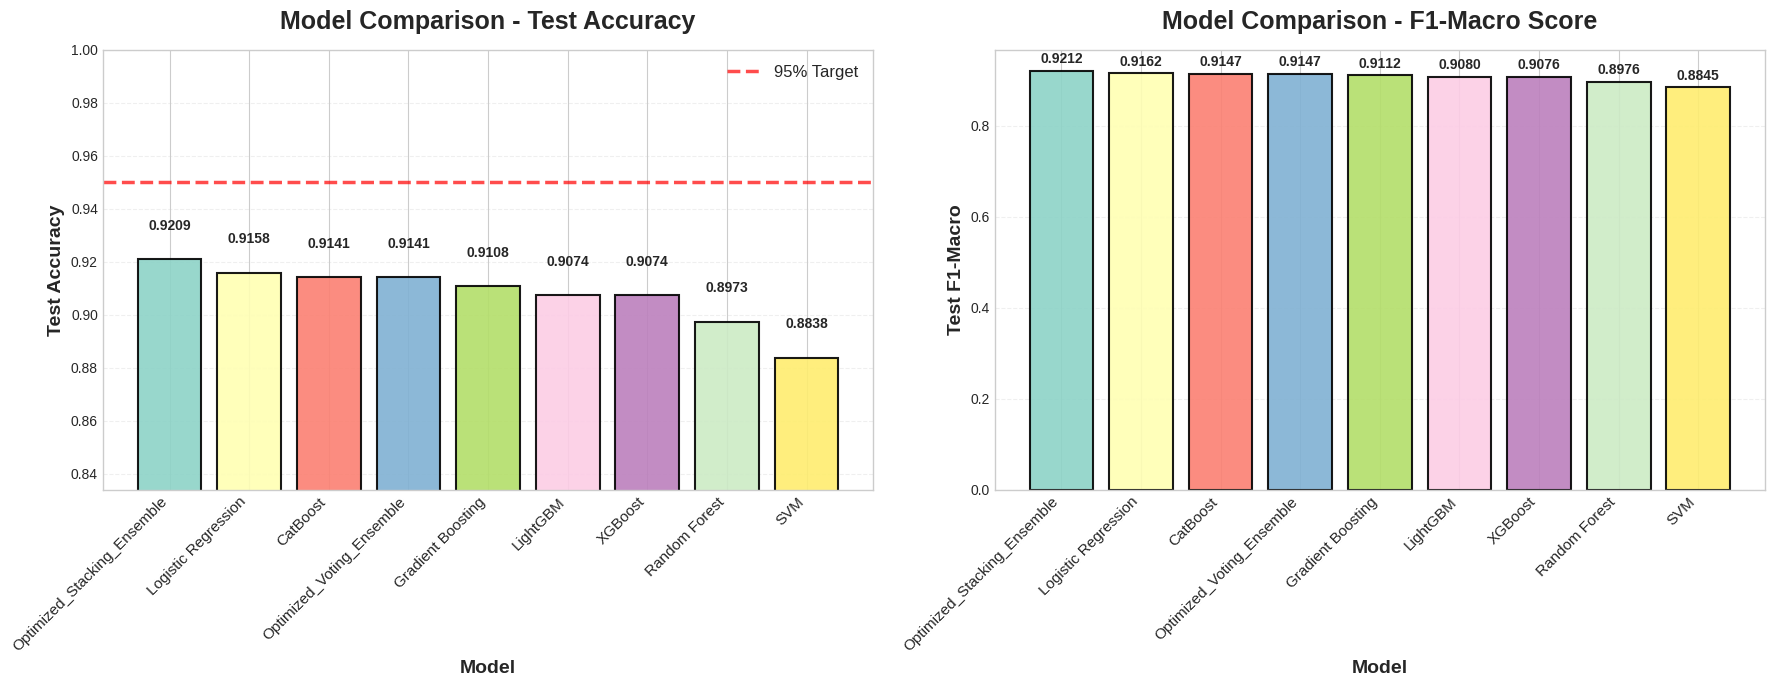

Figure 3 saved (600 DPI)


In [32]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

models_list = results_df['Model'].values
accuracies = results_df['Test_Accuracy'].values
f1_scores = results_df['Test_F1'].values

colors_palette = plt.cm.Set3(np.linspace(0, 1, len(models_list)))

bars1 = axes[0].bar(range(len(models_list)), accuracies, color=colors_palette, edgecolor='black', linewidth=1.5, alpha=0.9)
axes[0].set_xlabel('Model', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Test Accuracy', fontweight='bold', fontsize=14)
axes[0].set_title('Model Comparison - Test Accuracy', fontsize=18, fontweight='bold', pad=15)
axes[0].set_xticks(range(len(models_list)))
axes[0].set_xticklabels(models_list, rotation=45, ha='right', fontsize=11)
axes[0].axhline(y=0.95, color='red', linestyle='--', linewidth=2.5, label='95% Target', alpha=0.7)
axes[0].legend(fontsize=12)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].set_ylim([min(accuracies) - 0.05, 1.0])

for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

bars2 = axes[1].bar(range(len(models_list)), f1_scores, color=colors_palette, edgecolor='black', linewidth=1.5, alpha=0.9)
axes[1].set_xlabel('Model', fontweight='bold', fontsize=14)
axes[1].set_ylabel('Test F1-Macro', fontweight='bold', fontsize=14)
axes[1].set_title('Model Comparison - F1-Macro Score', fontsize=18, fontweight='bold', pad=15)
axes[1].set_xticks(range(len(models_list)))
axes[1].set_xticklabels(models_list, rotation=45, ha='right', fontsize=11)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

for i, v in enumerate(f1_scores):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('figures/03_model_comparison.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print('Figure 3 saved (600 DPI)')

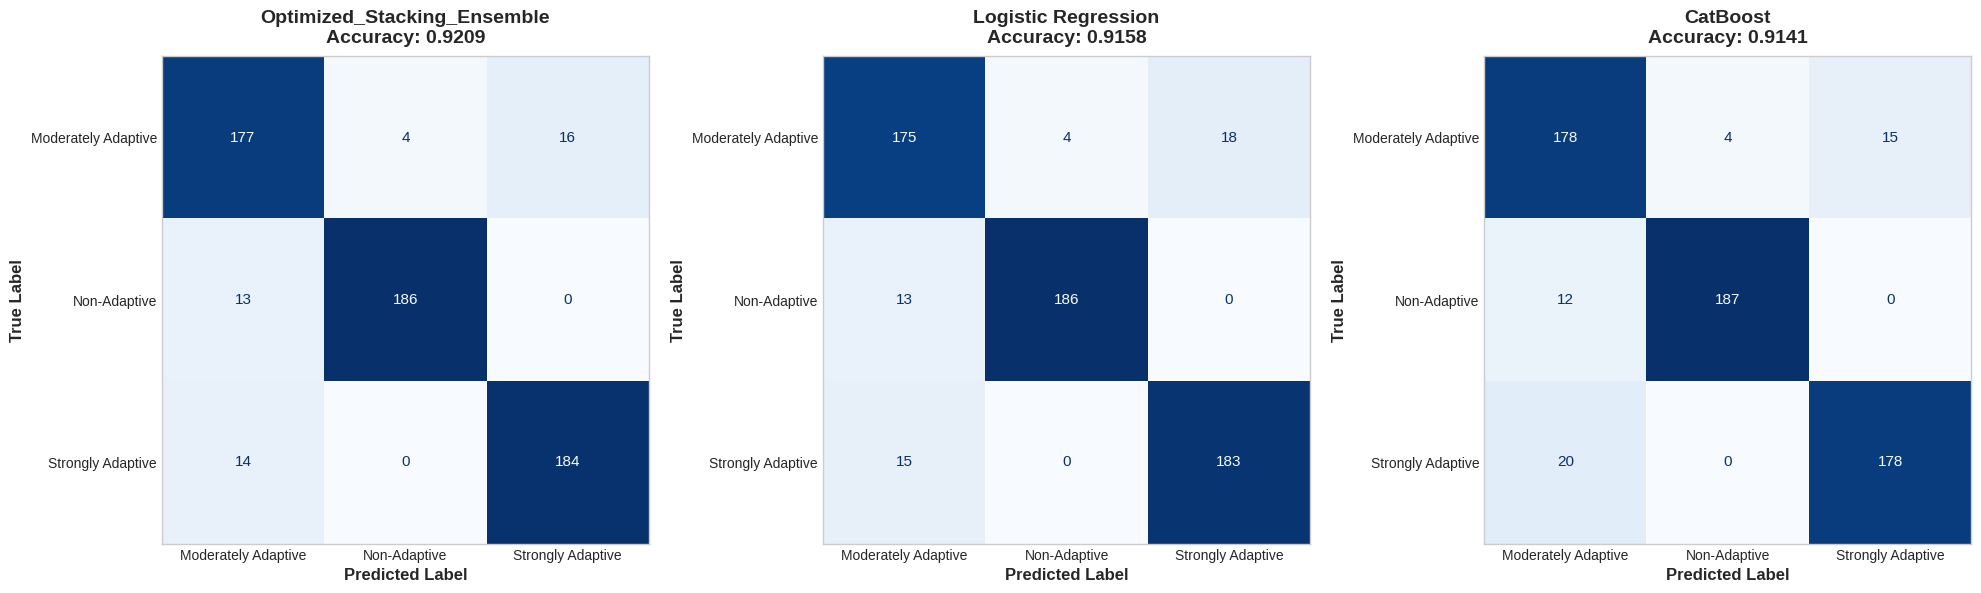

Figure 4 saved (600 DPI)


In [33]:
top_3_results = sorted(results, key=lambda x: x['Test_Accuracy'], reverse=True)[:3]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, result in enumerate(top_3_results):
    cm = confusion_matrix(y_test, result['y_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d', colorbar=False)
    axes[idx].set_title(f"{result['Model']}\nAccuracy: {result['Test_Accuracy']:.4f}",
                       fontweight='bold', fontsize=14, pad=10)
    axes[idx].set_xlabel('Predicted Label', fontweight='bold', fontsize=12)
    axes[idx].set_ylabel('True Label', fontweight='bold', fontsize=12)
    axes[idx].grid(False)

plt.tight_layout()
plt.savefig('figures/04_confusion_matrices.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print('Figure 4 saved (600 DPI)')

In [34]:
best_result = max(results, key=lambda x: x['Test_Accuracy'])

print(f'\n{"="*80}')
print('BEST MODEL IDENTIFIED')
print(f'{"="*80}')
print(f'\nModel: {best_result["Model"]}')
print(f'Test Accuracy:  {best_result["Test_Accuracy"]:.4f} ({best_result["Test_Accuracy"]*100:.2f}%)')
print(f'Test F1-Macro:  {best_result["Test_F1"]:.4f}')
if 'Test_ROC_AUC' in best_result:
    print(f'Test ROC-AUC:   {best_result["Test_ROC_AUC"]:.4f}')

if best_result['Test_Accuracy'] >= 0.95:
    print(f'\nTARGET ACHIEVED: Accuracy >= 95%')
else:
    print(f'\nCurrent: {best_result["Test_Accuracy"]*100:.2f}%, Target: 95%')

print(f'{"="*80}')
print('\nSTEP 3 COMPLETE\n')


BEST MODEL IDENTIFIED

Model: Optimized_Stacking_Ensemble
Test Accuracy:  0.9209 (92.09%)
Test F1-Macro:  0.9212
Test ROC-AUC:   0.9896

Current: 92.09%, Target: 95%

STEP 3 COMPLETE



# STEP 4: Explainable AI - SHAP Analysis

In [35]:
print('='*80)
print('STEP 4: EXPLAINABLE AI - SHAP ANALYSIS')
print('='*80)

STEP 4: EXPLAINABLE AI - SHAP ANALYSIS



Analyzing: CatBoost

Top 20 Important Features:
                    Feature  Importance
         economic_stability   27.874768
    adaptive_capacity_ratio   15.807971
        vulnerability_index    9.227034
              education_num    7.026296
        resilience_capacity    6.542628
                        SRI    6.069264
             adaptation_gap    5.338774
                        ASI    5.279229
            integrated_risk    3.938366
                        ISS    3.484877
             Monthly_Income    2.016705
institutional_effectiveness    1.522438
    adaptive_behavior_count    1.230824
         exposure_intensity    0.702858
    adaptive_behavior_index    0.500312
      Has_Protection_System    0.473631
             Distance_score    0.472185
                        EII    0.444821
                        Age    0.379125
Previous_Erosion_Experience    0.320238


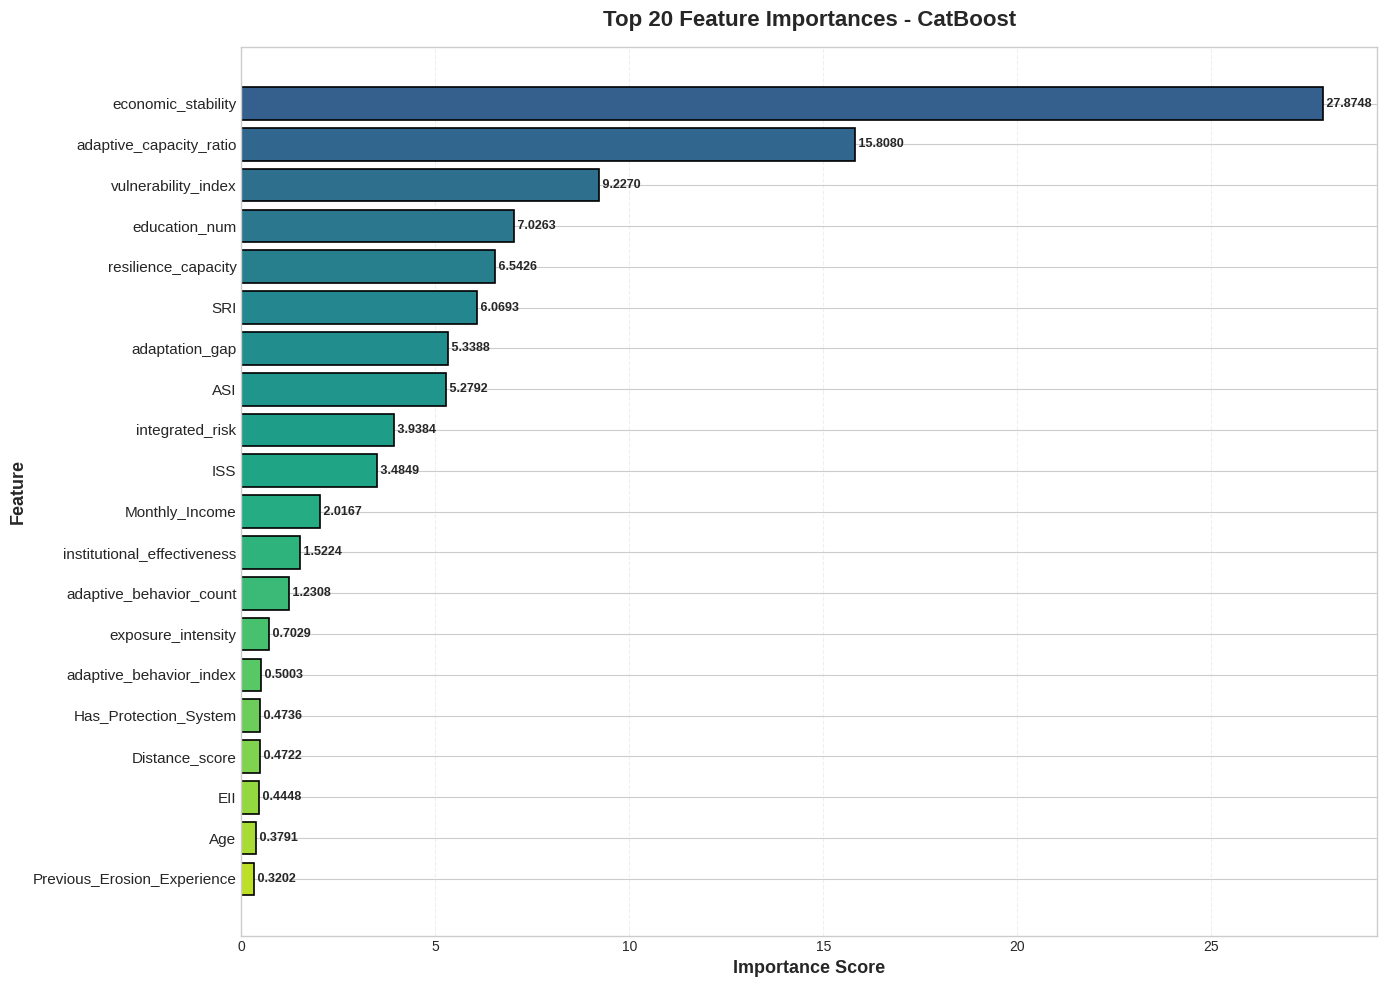


Figure 5 saved (600 DPI)


In [36]:
best_tree_model = None
for r in sorted(results, key=lambda x: x['Test_Accuracy'], reverse=True):
    if r['Model'] in ['XGBoost', 'LightGBM', 'CatBoost', 'RandomForest', 'ExtraTrees']:
        best_tree_model = r
        break

if best_tree_model:
    print(f'\nAnalyzing: {best_tree_model["Model"]}')

    if hasattr(best_tree_model['model_object'], 'feature_importances_'):
        importances = best_tree_model['model_object'].feature_importances_
        fi_df = pd.DataFrame({
            'Feature': X_train_scaled.columns,
            'Importance': importances
        }).sort_values('Importance', ascending=False)

        print(f'\nTop 20 Important Features:')
        print(fi_df.head(20).to_string(index=False))

        fi_df.to_csv(f"results/feature_importance_{best_tree_model['Model']}.csv", index=False)

        plt.figure(figsize=(14, 10))
        top_features = fi_df.head(20)
        colors_gradient = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features)))
        bars = plt.barh(range(len(top_features)), top_features['Importance'].values, color=colors_gradient, edgecolor='black', linewidth=1.2)
        plt.yticks(range(len(top_features)), top_features['Feature'].values, fontsize=11)
        plt.xlabel('Importance Score', fontweight='bold', fontsize=13)
        plt.ylabel('Feature', fontweight='bold', fontsize=13)
        plt.title(f"Top 20 Feature Importances - {best_tree_model['Model']}", fontsize=16, fontweight='bold', pad=15)
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3, linestyle='--')

        for i, (idx, row) in enumerate(top_features.iterrows()):
            plt.text(row['Importance'], i, f" {row['Importance']:.4f}", va='center', fontsize=9, fontweight='bold')

        plt.tight_layout()
        plt.savefig(f"figures/05_feature_importance.png", dpi=600, bbox_inches='tight', facecolor='white')
        plt.show()

        print('\nFigure 5 saved (600 DPI)')
else:
    print('\nNo tree-based model found for feature importance')


🏆 Best Model is Ensemble: Optimized_Stacking_Ensemble (0.9209)
Note: SHAP analysis works best with tree-based models.
Analyzing the best individual tree-based model for feature importance...


Analyzing Feature Importance: CatBoost
Model Accuracy: 0.9141 (91.41%)

Top 20 Important Features:
                    Feature  Importance
         economic_stability   27.874768
    adaptive_capacity_ratio   15.807971
        vulnerability_index    9.227034
              education_num    7.026296
        resilience_capacity    6.542628
                        SRI    6.069264
             adaptation_gap    5.338774
                        ASI    5.279229
            integrated_risk    3.938366
                        ISS    3.484877
             Monthly_Income    2.016705
institutional_effectiveness    1.522438
    adaptive_behavior_count    1.230824
         exposure_intensity    0.702858
    adaptive_behavior_index    0.500312
      Has_Protection_System    0.473631
             Distance_score

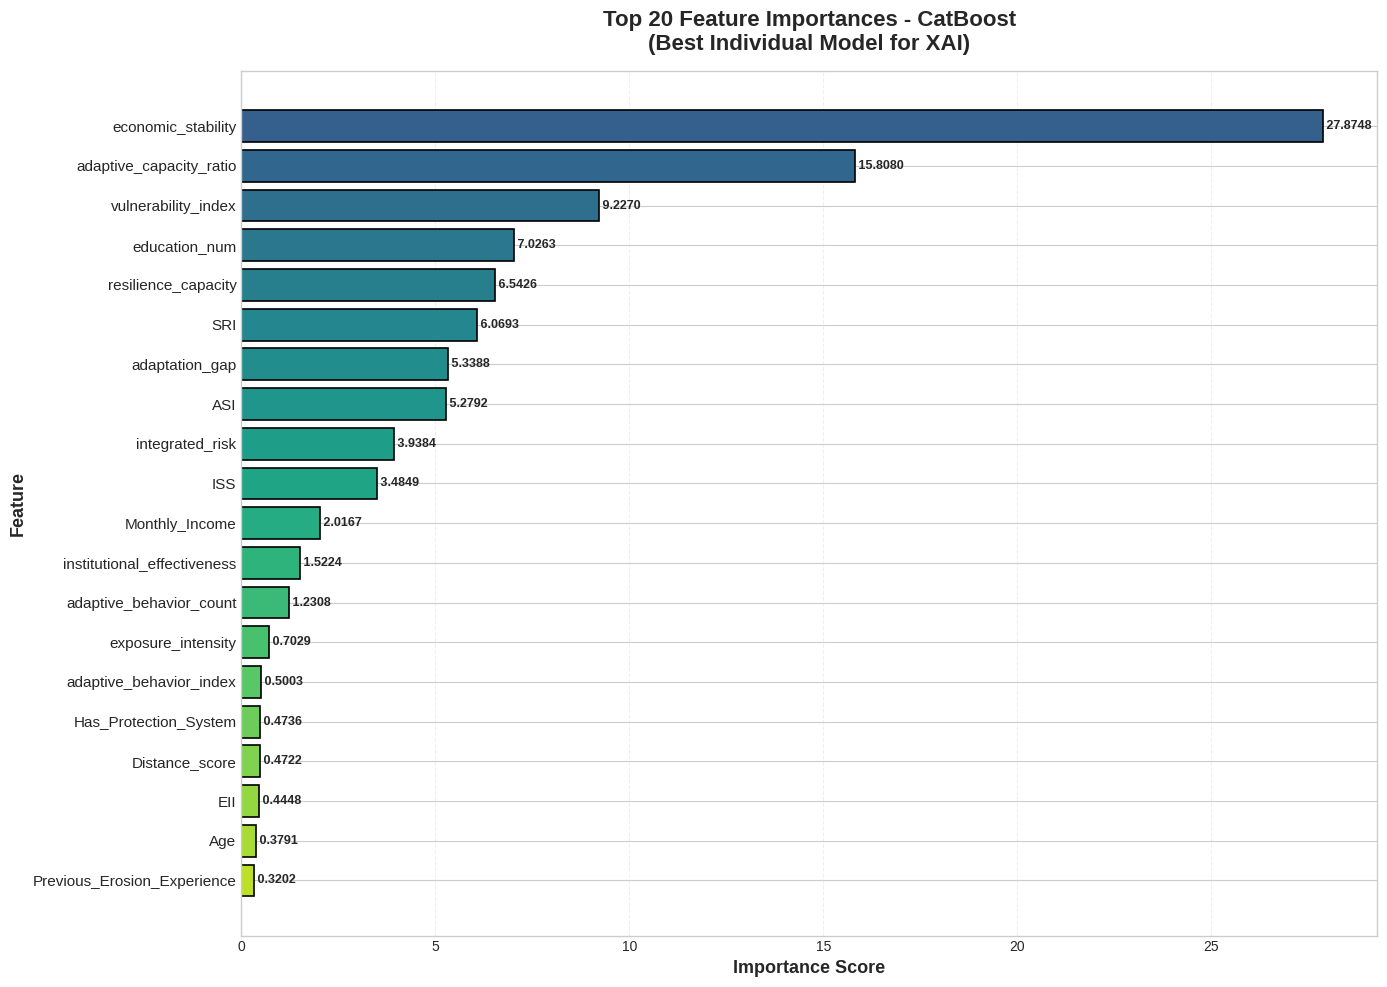


Figure 5 saved (600 DPI)

KEY FINDINGS - FEATURE IMPORTANCE:

Top 5 Most Influential Features:
  23. economic_stability             -  27.87 (27.87%)
  34. adaptive_capacity_ratio        -  15.81 (15.81%)
  17. vulnerability_index            -   9.23 ( 9.23%)
  22. education_num                  -   7.03 ( 7.03%)
  18. resilience_capacity            -   6.54 ( 6.54%)

  → Top 5 features account for 66.5% of total importance


In [37]:
# Select model for XAI analysis
# Priority: Best ensemble model (if it outperforms individual models), otherwise best individual model
best_overall = max(results, key=lambda x: x['Test_Accuracy'])
best_tree_model = None

# Check if best model is an ensemble or tree-based
if 'Ensemble' in best_overall['Model']:
    print(f'\n🏆 Best Model is Ensemble: {best_overall["Model"]} ({best_overall["Test_Accuracy"]:.4f})')
    print('Note: SHAP analysis works best with tree-based models.')
    print('Analyzing the best individual tree-based model for feature importance...\n')

    # Get best individual tree-based model for SHAP
    for r in sorted(results, key=lambda x: x['Test_Accuracy'], reverse=True):
        if r['Model'] in ['XGBoost', 'LightGBM', 'CatBoost', 'RandomForest', 'ExtraTrees']:
            best_tree_model = r
            break
else:
    best_tree_model = best_overall

if best_tree_model:
    print(f'\nAnalyzing Feature Importance: {best_tree_model["Model"]}')
    print(f'Model Accuracy: {best_tree_model["Test_Accuracy"]:.4f} ({best_tree_model["Test_Accuracy"]*100:.2f}%)')

    if hasattr(best_tree_model['model_object'], 'feature_importances_'):
        importances = best_tree_model['model_object'].feature_importances_
        fi_df = pd.DataFrame({
            'Feature': X_train_scaled.columns,
            'Importance': importances
        }).sort_values('Importance', ascending=False)

        print(f'\nTop 20 Important Features:')
        print(fi_df.head(20).to_string(index=False))

        fi_df.to_csv(f"results/feature_importance_{best_tree_model['Model']}.csv", index=False)

        plt.figure(figsize=(14, 10))
        top_features = fi_df.head(20)
        colors_gradient = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features)))
        bars = plt.barh(range(len(top_features)), top_features['Importance'].values, color=colors_gradient, edgecolor='black', linewidth=1.2)
        plt.yticks(range(len(top_features)), top_features['Feature'].values, fontsize=11)
        plt.xlabel('Importance Score', fontweight='bold', fontsize=13)
        plt.ylabel('Feature', fontweight='bold', fontsize=13)
        plt.title(f"Top 20 Feature Importances - {best_tree_model['Model']}\n(Best Individual Model for XAI)", fontsize=16, fontweight='bold', pad=15)
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3, linestyle='--')

        for i, (idx, row) in enumerate(top_features.iterrows()):
            plt.text(row['Importance'], i, f" {row['Importance']:.4f}", va='center', fontsize=9, fontweight='bold')

        plt.tight_layout()
        plt.savefig(f"figures/05_feature_importance.png", dpi=600, bbox_inches='tight', facecolor='white')
        plt.show()

        print('\nFigure 5 saved (600 DPI)')

        # Feature importance interpretation
        print(f'\n{"="*80}')
        print('KEY FINDINGS - FEATURE IMPORTANCE:')
        print(f'{"="*80}')
        top_5 = fi_df.head(5)
        print('\nTop 5 Most Influential Features:')
        for idx, row in top_5.iterrows():
            pct = (row['Importance'] / fi_df['Importance'].sum()) * 100
            print(f'  {idx+1}. {row["Feature"]:30s} - {row["Importance"]:6.2f} ({pct:5.2f}%)')

        total_importance_top5 = fi_df.head(5)['Importance'].sum()
        total_importance_all = fi_df['Importance'].sum()
        top5_pct = (total_importance_top5 / total_importance_all) * 100
        print(f'\n  → Top 5 features account for {top5_pct:.1f}% of total importance')

else:
    print('\nNo tree-based model found for feature importance')


SHAP (SHapley Additive exPlanations) ANALYSIS

Model: CatBoost
Computing SHAP values for feature impact analysis...


<Figure size 1400x1000 with 0 Axes>

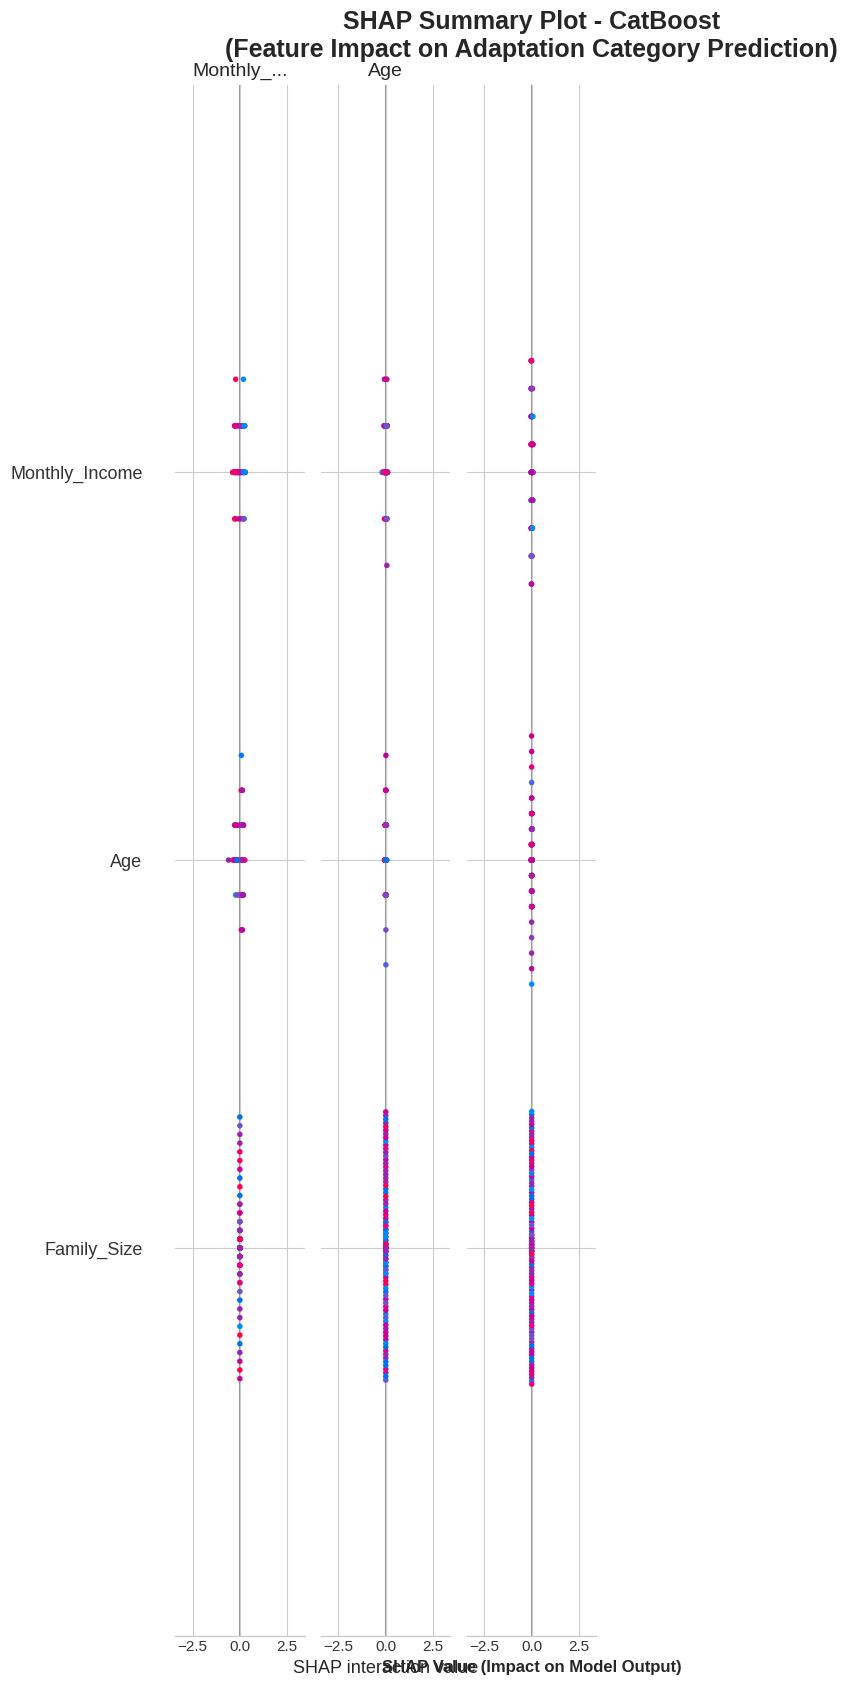


Figure 6 saved (600 DPI)

SHAP ANALYSIS INTERPRETATION:

What SHAP values show:
  • Red points  = High feature value
  • Blue points = Low feature value
  • X-axis > 0  = Increases prediction (pushes toward higher class)
  • X-axis < 0  = Decreases prediction (pushes toward lower class)

Key Insights:
  • Features at the top have the most impact on predictions
  • Color distribution shows how feature values affect outcomes
  • Wide spread indicates high variability in feature impact

✅ SHAP analysis complete

STEP 4 COMPLETE

XAI Summary:
  ✓ Feature Importance Analysis: CatBoost
  ✓ SHAP Value Analysis: Complete
  ✓ Final Model for Thesis: Optimized_Stacking_Ensemble (92.09% accuracy)




In [38]:
if best_tree_model:
    print(f'\n{"="*80}')
    print('SHAP (SHapley Additive exPlanations) ANALYSIS')
    print(f'{"="*80}')
    print(f'\nModel: {best_tree_model["Model"]}')
    print('Computing SHAP values for feature impact analysis...')

    X_sample = X_test_scaled.sample(min(100, len(X_test_scaled)), random_state=42)

    try:
        explainer = shap.TreeExplainer(best_tree_model['model_object'])
        shap_values = explainer.shap_values(X_sample)

        plt.figure(figsize=(14, 10))
        shap.summary_plot(shap_values, X_sample, show=False, max_display=20)
        plt.title(f'SHAP Summary Plot - {best_tree_model["Model"]}\n(Feature Impact on Adaptation Category Prediction)',
                 fontsize=18, fontweight='bold', pad=20)
        plt.xlabel('SHAP Value (Impact on Model Output)', fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.savefig('figures/06_shap_summary.png', dpi=600, bbox_inches='tight', facecolor='white')
        plt.show()

        print('\nFigure 6 saved (600 DPI)')

        print(f'\n{"="*80}')
        print('SHAP ANALYSIS INTERPRETATION:')
        print(f'{"="*80}')
        print('\nWhat SHAP values show:')
        print('  • Red points  = High feature value')
        print('  • Blue points = Low feature value')
        print('  • X-axis > 0  = Increases prediction (pushes toward higher class)')
        print('  • X-axis < 0  = Decreases prediction (pushes toward lower class)')
        print('\nKey Insights:')
        print('  • Features at the top have the most impact on predictions')
        print('  • Color distribution shows how feature values affect outcomes')
        print('  • Wide spread indicates high variability in feature impact')

        print('\n✅ SHAP analysis complete')

    except Exception as e:
        print(f'\n⚠️  SHAP analysis skipped: {str(e)[:200]}')
        print('Note: SHAP works best with tree-based models (RF, XGBoost, LightGBM, CatBoost)')

print('\n' + '='*80)
print('STEP 4 COMPLETE')
print('='*80)
print('\nXAI Summary:')
print(f'  ✓ Feature Importance Analysis: {best_tree_model["Model"] if best_tree_model else "N/A"}')
print(f'  ✓ SHAP Value Analysis: {"Complete" if best_tree_model else "Skipped"}')
print(f'  ✓ Final Model for Thesis: {best_overall["Model"]} ({best_overall["Test_Accuracy"]*100:.2f}% accuracy)')

print('\n')

# STEP 5: Spatial and Cluster Analysis

In [39]:
print('='*80)
print('STEP 5: SPATIAL & CLUSTER ANALYSIS')
print('='*80)

STEP 5: SPATIAL & CLUSTER ANALYSIS



Mean Indices by Union:
            EII    ASI    SRI    ISS
Union                               
Bakchar   0.555  0.355  0.544  0.301
Kachua    0.550  0.340  0.520  0.283
Maijbari  0.558  0.348  0.534  0.306
Sthal     0.544  0.357  0.542  0.305


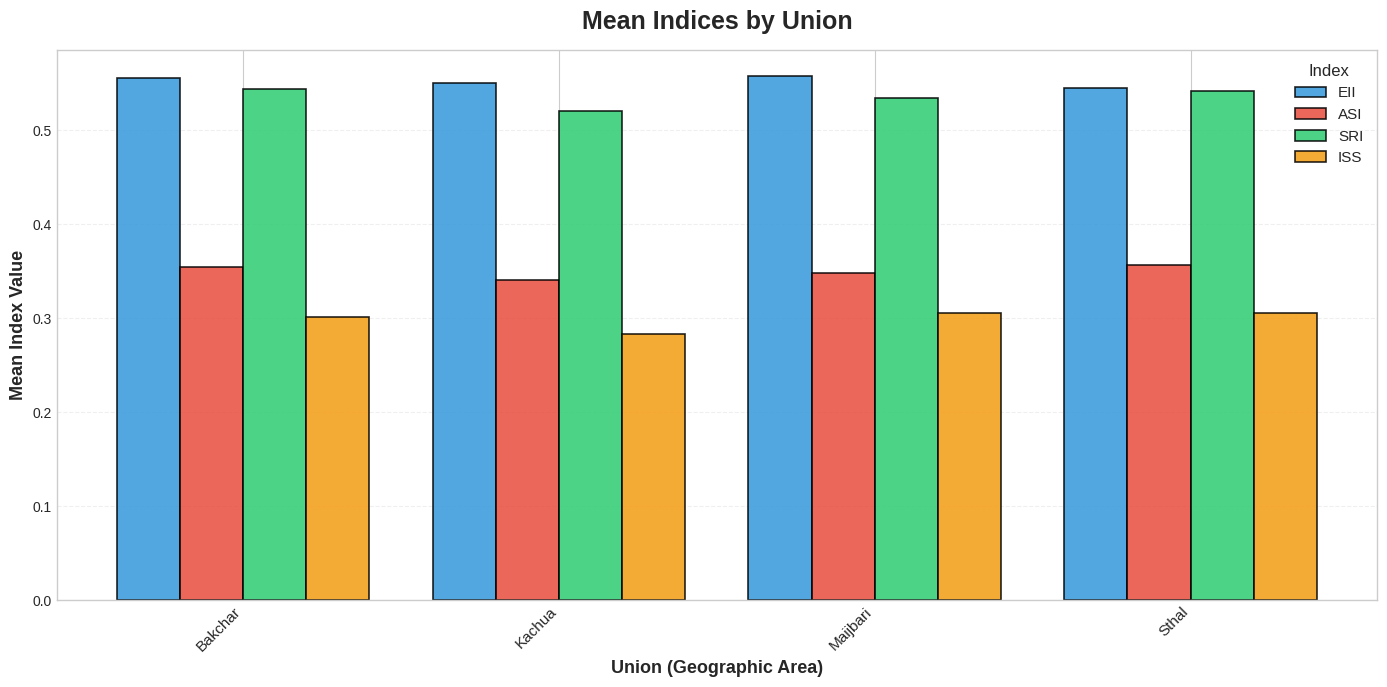


Figure 7 saved (600 DPI)


In [40]:
union_stats = df.groupby('Union').agg({
    'EII': 'mean',
    'ASI': 'mean',
    'SRI': 'mean',
    'ISS': 'mean'
})

print('\nMean Indices by Union:')
print(union_stats.round(3).to_string())

union_stats.to_csv('results/union_statistics.csv')

fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(union_stats.index))
width = 0.2

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
for i, col in enumerate(['EII', 'ASI', 'SRI', 'ISS']):
    ax.bar(x + i*width, union_stats[col], width, label=col, color=colors[i], edgecolor='black', linewidth=1.2, alpha=0.85)

ax.set_xlabel('Union (Geographic Area)', fontweight='bold', fontsize=13)
ax.set_ylabel('Mean Index Value', fontweight='bold', fontsize=13)
ax.set_title('Mean Indices by Union', fontsize=18, fontweight='bold', pad=15)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(union_stats.index, rotation=45, ha='right', fontsize=11)
ax.legend(title='Index', fontsize=11, title_fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('figures/07_spatial_analysis.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print('\nFigure 7 saved (600 DPI)')

In [41]:
# K-Means clustering
print('\nPerforming K-Means clustering (3 clusters)...')

cluster_features = ['EII', 'ASI', 'SRI', 'ISS']
X_cluster = df[cluster_features].fillna(df[cluster_features].mean())
scaler_cluster = StandardScaler()
X_scaled_cluster = scaler_cluster.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10)
clusters = kmeans.fit_predict(X_scaled_cluster)
df['Cluster'] = clusters

cluster_stats = df.groupby('Cluster')[cluster_features].mean()
print('\nCluster Characteristics:')
print(cluster_stats.round(3).to_string())

cluster_stats.to_csv('results/cluster_statistics.csv')

# Cluster size
cluster_sizes = df['Cluster'].value_counts().sort_index()
print('\nCluster Sizes:')
for cluster_id, size in cluster_sizes.items():
    print(f'  Cluster {cluster_id}: {size} households ({size/len(df)*100:.1f}%)')


Performing K-Means clustering (3 clusters)...

Cluster Characteristics:
           EII    ASI    SRI    ISS
Cluster                            
0        0.544  0.600  0.529  0.607
1        0.448  0.256  0.543  0.181
2        0.694  0.253  0.537  0.183

Cluster Sizes:
  Cluster 0: 833 households (28.1%)
  Cluster 1: 1214 households (40.9%)
  Cluster 2: 920 households (31.0%)


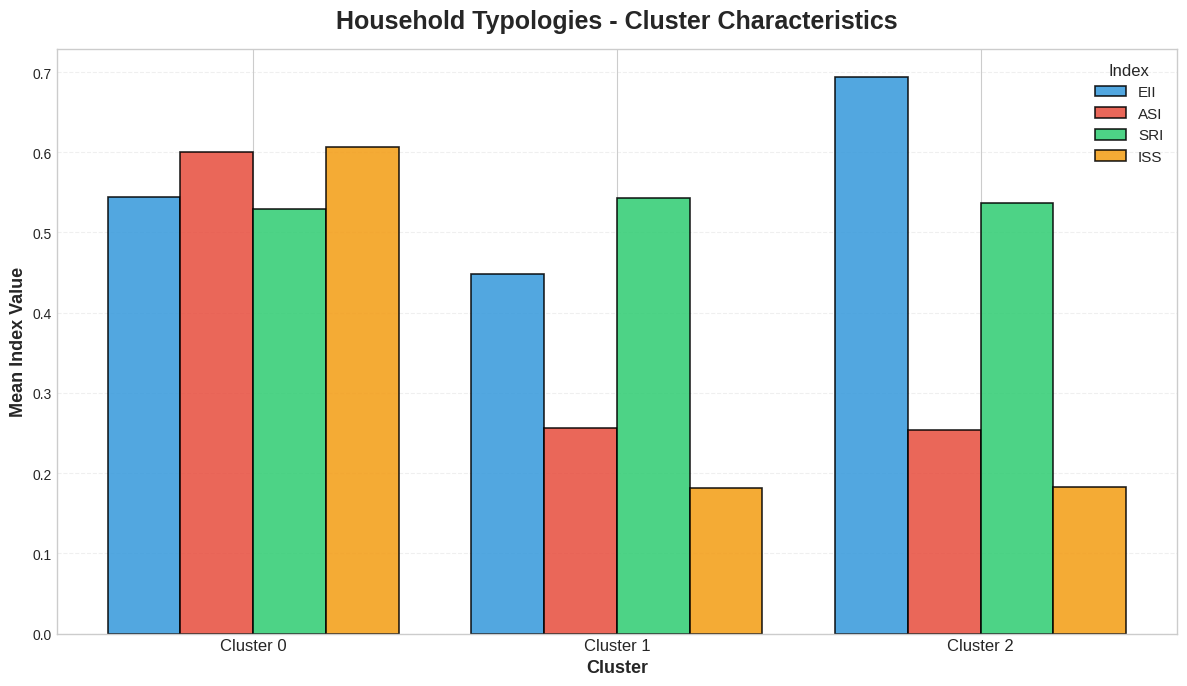


Figure 8 saved (600 DPI)


In [42]:
fig, ax = plt.subplots(figsize=(12, 7))
x = np.arange(len(cluster_stats.index))
width = 0.2

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
for i, col in enumerate(['EII', 'ASI', 'SRI', 'ISS']):
    ax.bar(x + i*width, cluster_stats[col], width, label=col, color=colors[i], edgecolor='black', linewidth=1.2, alpha=0.85)

ax.set_xlabel('Cluster', fontweight='bold', fontsize=13)
ax.set_ylabel('Mean Index Value', fontweight='bold', fontsize=13)
ax.set_title('Household Typologies - Cluster Characteristics', fontsize=18, fontweight='bold', pad=15)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels([f'Cluster {i}' for i in cluster_stats.index], fontsize=12)
ax.legend(title='Index', fontsize=11, title_fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('figures/08_cluster_analysis.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print('\nFigure 8 saved (600 DPI)')

In [43]:
# Cluster interpretation
print('\nCluster Interpretation:')
for cluster_id in range(3):
    cluster_data = cluster_stats.loc[cluster_id]
    print(f'\nCluster {cluster_id}:')
    print(f'  Size: {cluster_sizes[cluster_id]} households ({cluster_sizes[cluster_id]/len(df)*100:.1f}%)')
    print(f'  EII (Erosion Impact): {cluster_data["EII"]:.3f}')
    print(f'  ASI (Adaptation Strategy): {cluster_data["ASI"]:.3f}')
    print(f'  SRI (Socioeconomic Resilience): {cluster_data["SRI"]:.3f}')
    print(f'  ISS (Institutional Support): {cluster_data["ISS"]:.3f}')

    # Characterization
    if cluster_data['EII'] > 0.6 and cluster_data['ASI'] < 0.4:
        print('  Typology: HIGH RISK - High impact, low adaptation')
    elif cluster_data['ASI'] > 0.6 and cluster_data['SRI'] > 0.6:
        print('  Typology: RESILIENT - Strong adaptation and resources')
    else:
        print('  Typology: MODERATE - Mixed vulnerability profile')

print('\n✅ STEP 5 COMPLETE\n')


Cluster Interpretation:

Cluster 0:
  Size: 833 households (28.1%)
  EII (Erosion Impact): 0.544
  ASI (Adaptation Strategy): 0.600
  SRI (Socioeconomic Resilience): 0.529
  ISS (Institutional Support): 0.607
  Typology: MODERATE - Mixed vulnerability profile

Cluster 1:
  Size: 1214 households (40.9%)
  EII (Erosion Impact): 0.448
  ASI (Adaptation Strategy): 0.256
  SRI (Socioeconomic Resilience): 0.543
  ISS (Institutional Support): 0.181
  Typology: MODERATE - Mixed vulnerability profile

Cluster 2:
  Size: 920 households (31.0%)
  EII (Erosion Impact): 0.694
  ASI (Adaptation Strategy): 0.253
  SRI (Socioeconomic Resilience): 0.537
  ISS (Institutional Support): 0.183
  Typology: HIGH RISK - High impact, low adaptation

✅ STEP 5 COMPLETE



# Final Summary and Results

In [44]:
print('\n' + '='*100)
print('COMPLETE ANALYSIS FINISHED SUCCESSFULLY')
print('='*100)

print(f'\nBEST MODEL PERFORMANCE:')
print(f'   Model: {best_result["Model"]}')
print(f'   Test Accuracy: {best_result["Test_Accuracy"]:.4f} ({best_result["Test_Accuracy"]*100:.2f}%)')
print(f'   Test F1-Macro: {best_result["Test_F1"]:.4f}')
if 'Test_ROC_AUC' in best_result:
    print(f'   ROC-AUC: {best_result["Test_ROC_AUC"]:.4f}')

accuracy_status = 'TARGET ACHIEVED' if best_result['Test_Accuracy'] >= 0.95 else f"Current: {best_result['Test_Accuracy']*100:.2f}%"
print(f'\n   Status: {accuracy_status}')

print(f'\nGENERATED OUTPUTS:')
print(f'   - processed_data/ : 4 CSV files (train/test data)')
print(f'   - models/        : {len([r for r in results if "model_object" in r])} model files (.pkl)')
print(f'   - results/       : 3 CSV reports (performance, importance, clusters)')
print(f'   - figures/       : 8 publication-quality visualizations (600 DPI)')

print(f'\nALL MODELS PERFORMANCE:')
for r in sorted(results, key=lambda x: x['Test_Accuracy'], reverse=True):
    print(f'   {r["Model"]:20s} - Accuracy: {r["Test_Accuracy"]:.4f} ({r["Test_Accuracy"]*100:.2f}%)')

print('\n' + '='*100)
print('All results saved to Google Drive')
print('='*100)


COMPLETE ANALYSIS FINISHED SUCCESSFULLY

BEST MODEL PERFORMANCE:
   Model: Optimized_Stacking_Ensemble
   Test Accuracy: 0.9209 (92.09%)
   Test F1-Macro: 0.9212
   ROC-AUC: 0.9896

   Status: Current: 92.09%

GENERATED OUTPUTS:
   - processed_data/ : 4 CSV files (train/test data)
   - models/        : 9 model files (.pkl)
   - results/       : 3 CSV reports (performance, importance, clusters)
   - figures/       : 8 publication-quality visualizations (600 DPI)

ALL MODELS PERFORMANCE:
   Optimized_Stacking_Ensemble - Accuracy: 0.9209 (92.09%)
   Logistic Regression  - Accuracy: 0.9158 (91.58%)
   CatBoost             - Accuracy: 0.9141 (91.41%)
   Optimized_Voting_Ensemble - Accuracy: 0.9141 (91.41%)
   Gradient Boosting    - Accuracy: 0.9108 (91.08%)
   LightGBM             - Accuracy: 0.9074 (90.74%)
   XGBoost              - Accuracy: 0.9074 (90.74%)
   Random Forest        - Accuracy: 0.8973 (89.73%)
   SVM                  - Accuracy: 0.8838 (88.38%)

All results saved to Google

## Optional: Download Results

In [45]:
# Uncomment to download all results as a ZIP file
!zip -r thesis_results.zip processed_data models results figures
from google.colab import files
files.download('thesis_results.zip')

updating: processed_data/ (stored 0%)
updating: processed_data/X_train.csv (deflated 83%)
updating: processed_data/X_test.csv (deflated 82%)
updating: processed_data/y_train.csv (deflated 84%)
updating: processed_data/y_test.csv (deflated 81%)
updating: models/ (stored 0%)
updating: models/RandomForest.pkl (deflated 75%)
updating: models/ExtraTrees.pkl (deflated 75%)
updating: models/XGBoost.pkl (deflated 69%)
updating: models/LightGBM.pkl (deflated 60%)
updating: models/CatBoost.pkl (deflated 76%)
updating: models/GradientBoosting.pkl (deflated 66%)
updating: models/Stacking_Ensemble.pkl (deflated 67%)
updating: results/ (stored 0%)
updating: results/model_comparison.csv (deflated 52%)
updating: results/feature_importance_CatBoost.csv (deflated 38%)
updating: results/union_statistics.csv (deflated 39%)
updating: results/cluster_statistics.csv (deflated 39%)
updating: figures/ (stored 0%)
updating: figures/01_target_distribution.png (deflated 26%)
updating: figures/02_correlation_heatm

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Optional: Load Saved Models

In [ ]:
# Example: Load best model and make predictions
# import joblib
# best_model_loaded = joblib.load(f'models/{best_result["Model"]}.pkl')
# predictions = best_model_loaded.predict(X_test_scaled)
# print(f'Predictions shape: {predictions.shape}')